In [1]:

import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing
import re
from collections import Counter
import sklearn


In [2]:
#Vienna

vienna_listings = 'http://data.insideairbnb.com/austria/vienna/vienna/2022-09-11/data/listings.csv.gz'
df_vienna = pd.read_csv(vienna_listings, compression='gzip')
df_vienna.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15883,https://www.airbnb.com/rooms/15883,20220911230927,2022-09-12,city scrape,b&b near Old Danube river,"Four rooms, each one differently and individua...",small and personal<br /><br />Four rooms at th...,https://a0.muscache.com/pictures/18eff738-a737...,62142,...,4.86,4.71,4.50,NaN,f,4,2,0,0,0.15
1,38768,https://www.airbnb.com/rooms/38768,20220911230927,2022-09-12,city scrape,central cityapartement- wifi- nice neighbourhood,39m² apartment with beautiful courtyard of the...,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.93,4.75,4.69,NaN,t,3,3,0,0,2.50
2,40625,https://www.airbnb.com/rooms/40625,20220911230927,2022-09-12,city scrape,"Near Palace Schönbrunn, Apt. 1",Welcome to my Apt. 1!<br /><br />This is a 2be...,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.93,4.59,4.70,NaN,t,15,14,1,0,1.23
3,392757,https://www.airbnb.com/rooms/392757,20220911230927,2022-09-12,city scrape,VCA3 Palais Brambilla - studio with city views,Palais Brambilla is an oasis located in the hi...,"The neighborhood offers a wide range of cafés,...",https://a0.muscache.com/pictures/miso/Hosting-...,1833176,...,4.91,4.89,4.59,NaN,f,4,4,0,0,0.79
4,51287,https://www.airbnb.com/rooms/51287,20220911230927,2022-09-12,city scrape,little studio- next to citycenter- wifi- nice ...,small studio in new renovated old house and ve...,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.86,4.58,NaN,f,3,3,0,0,2.45


Vienna chosen columns for predicting a price are:
ID, neighbourhood_cleansed, amnenties, acommodates,bathroom_type,bedrooms, room_type, property_type,review_location,review_cleaninnes, communication,checkin


In [3]:
df_vienna_price = df_vienna[['neighbourhood_cleansed','room_type','accommodates',
                            'bathrooms_text','bedrooms','amenities','review_scores_cleanliness'
                             ,'review_scores_location','price']]

In [4]:
df_vienna_price

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,amenities,review_scores_cleanliness,review_scores_location,price
0,Donaustadt,Hotel room,3,1 private bath,1.0,"[""Essentials"", ""Heating"", ""High chair"", ""Hange...",4.93,4.71,$110.00
1,Leopoldstadt,Entire home/apt,5,1 bath,1.0,"[""Dishes and silverware"", ""Cooking basics"", ""S...",4.65,4.75,$69.00
2,Rudolfsheim-Fnfhaus,Entire home/apt,6,1 bath,2.0,"[""Babysitter recommendations"", ""Dishes and sil...",4.88,4.59,$145.00
3,Innere Stadt,Entire home/apt,2,1 bath,1.0,"[""Dishes and silverware"", ""Shampoo"", ""Long ter...",4.55,4.89,$100.00
4,Leopoldstadt,Entire home/apt,3,1 bath,NaN,"[""Dishes and silverware"", ""Cooking basics"", ""S...",4.51,4.86,$68.00
...,...,...,...,...,...,...,...,...,...
11792,Donaustadt,Entire home/apt,5,2 baths,2.0,"[""Private entrance"", ""Essentials"", ""Iron"", ""Ha...",NaN,NaN,$170.00
11793,Simmering,Entire home/apt,3,1 bath,1.0,"[""Dishes and silverware"", ""Paid parking lot of...",5.00,4.17,$150.00
11794,Simmering,Entire home/apt,8,1 bath,2.0,"[""Private entrance"", ""Washer"", ""Essentials"", ""...",3.00,5.00,$150.00
11795,Liesing,Entire home/apt,2,1 bath,1.0,"[""Dishes and silverware"", ""Cooking basics"", ""F...",5.00,5.00,$50.00


In [5]:
import warnings
warnings.filterwarnings('ignore')
df_vienna_price.rename(columns = {'neighbourhood_cleansed':'neighbourhood','bathrooms_text':'bathroom',
                                 'review_scores_cleanliness':'review_clean', 
                                 'review_scores_location' :'review_location' }, inplace = True)

Data Types of columns before cleansing and transforming


In [6]:
df_vienna_price_types = pd.DataFrame(df_vienna_price.dtypes, columns=["type"])
df_vienna_price_types

,type
neighbourhood,object
room_type,object
accommodates,int64
bathroom,object
bedrooms,float64
amenities,object
review_clean,float64
review_location,float64
price,object


In [7]:
df_vienna_price.bathroom.fillna(0,inplace=True)






Bathroom Types : private bath,shared baths,half-bath and containing numbers 1,1.5,2,2.5 .....
                  
                   
Missing values are deleted because we had little missing values

## Data Cleansing

Price column - Striping the $ sign and , from the values and then transforming into a float data type

Neighbourhood column - Replace special german alphabet characters with latin letters and then transforming 
categorical data with one hot encoding

Bathroom - Spliting the number value from string, creating a new column called bathroom_number containing that value
then transforming  categorical data with one hot encoding

Room Type - Transforming categorical data with one hot encoding into 4 different columns

Amenities - Extracting the String values from the column for basic amenities and transforming it with one hot encoding


In [8]:
df_vienna_price.price = df_vienna_price.price.str.replace("$","")

df_vienna_price.price = df_vienna_price.price.str.replace(",","")
df_vienna_price.price = df_vienna_price.price.str.strip(" ")




In [9]:
df_vienna_price.price = df_vienna_price.price.astype(np.float64)



In [10]:
df_vienna_price.neighbourhood.unique()
df_vienna_price.neighbourhood = df_vienna_price.neighbourhood.str.replace("Rudolfsheim-F\x9fnfhaus","Rudolfsheim-Fufnfhaus")
df_vienna_price.neighbourhood = df_vienna_price.neighbourhood.str.replace("Landstra§e","Landstrase")
df_vienna_price.neighbourhood = df_vienna_price.neighbourhood.str.replace("W\x8ahring","Wahring")
df_vienna_price.neighbourhood = df_vienna_price.neighbourhood.str.replace("D\x9abling","Dobling")






<AxesSubplot:xlabel='neighbourhood', ylabel='price'>

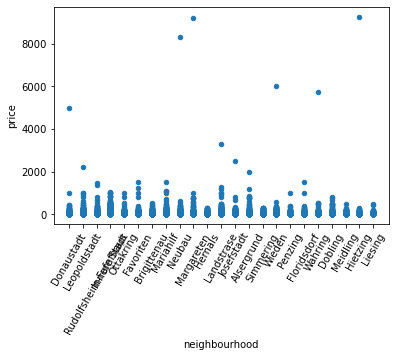

In [11]:
df_vienna_price.plot.scatter(x = 'neighbourhood', y = 'price',rot = 60)

In [12]:
df_vienna_price.neighbourhood.unique()

array(['Donaustadt', 'Leopoldstadt', 'Rudolfsheim-Fufnfhaus',
       'Innere Stadt', 'Ottakring', 'Favoriten', 'Brigittenau',
       'Mariahilf', 'Neubau', 'Margareten', 'Hernals', 'Landstrase',
       'Josefstadt', 'Alsergrund', 'Simmering', 'Wieden', 'Penzing',
       'Floridsdorf', 'Wahring', 'Dobling', 'Meidling', 'Hietzing',
       'Liesing'], dtype=object)

In [13]:
#df_vienna_price[df_vienna_price['amenities'].str.contains("Microwave")]

wifi = df_vienna_price[(df_vienna_price.amenities.str.contains('(?i)wifi'))]
kitchen =  df_vienna_price[(df_vienna_price.amenities.str.contains('(?i)cooking'))]


In [14]:
review_miss_sum = df_vienna_price['review_location'].isnull().sum()
perc = review_miss_sum / df_vienna_price.shape[0] * 100
review_miss_sum, perc

(2024, 17.156904297702805)

** Checking for missing data

Approximately 17% of review values (review_clean,review_checkin,review_location) are missing...


In [15]:
from sklearn.preprocessing import OneHotEncoder
df_vienna_price = pd.get_dummies(df_vienna_price, columns = ['neighbourhood'])



In [16]:
df_vienna_price.bathroom.unique()
#df_vienna_price.bathroom.isnummeric()
#df_vienna_price['Bathroom_NumberFloat'] = df_vienna_price['bathroom'].astype('str').str.extractall(r"(\d+\.\d+)").unstack().fillna('').sum(axis=1).astype(float)
#df_vienna_price['Bathroom_Number'] = df_vienna_price['bathroom'].astype('str').str.extractall('\d+').unstack().fillna('').sum(axis=1).astype(float)


df_vienna_price['bathroom_number'] = df_vienna_price['bathroom'].str.extract('([-+]?\d*\.?\d+)').astype(np.float64)
df_vienna_price['shared_bathroom'] = df_vienna_price['bathroom'].str.contains('shared')
df_vienna_price['private_bathroom'] = df_vienna_price['bathroom'].str.contains('private')
df_vienna_price['bath_bathroom'] = df_vienna_price['bathroom'].str.contains('baths')

#df_vienna_price = pd.get_dummies(df_vienna_price, columns = ['shared_bathroom','private_bathroom','bath_bathroom'])


#1.5,2.5,4.5,3.5,7.5,

#df_vienna_price.drop(['shared_bathroom_False','private_bathroom_False','bath_bathroom_False'],inplace=True, axis=1)

df_vienna_price = pd.get_dummies(df_vienna_price, columns = ['shared_bathroom','private_bathroom','bath_bathroom'])




In [17]:

df_vienna_price.columns
df_vienna_price.drop(['shared_bathroom_False','private_bathroom_False','bath_bathroom_False'],inplace=True, axis=1)



In [18]:
df_vienna_price = df_vienna_price.rename(columns={"shared_bathroom_True": "shared_bathroom", "private_bathroom_True": "private_bathroom", "bath_bathroom_True": "bath_bathroom"})

In [19]:
df_vienna_price = pd.get_dummies(df_vienna_price, columns = ['room_type'])



In [20]:
df_vienna_price = df_vienna_price.rename(columns={"room_type_Entire home/apt": "Entire_home/apt", "room_type_Hotel room": "Hotel_room", "room_type_Private room": "Private_room","room_type_Shared room": "Shared_room"})

In [21]:
df_vienna_price.drop(['bathroom'],inplace = True, axis=1)

In [22]:
df_vienna_price['amenities_ab'] = df_vienna_price['amenities'].str.lower()

df_vienna_price['amenities_ab'].str.count('refrigerator').sum()
#dishesandsilverware = 7527, wifi 11698,, parking = 6367, kitchen = 11128,heating = 10968 
#wifi, hot water, hair dryer, kitchen, refrigerator, heating , iron = 8207, hair dryer

7415

In [23]:
df_vienna_price['parking_amn'] = df_vienna_price['amenities_ab'].str.contains('parking')
df_vienna_price['wifi_amn'] = df_vienna_price['amenities_ab'].str.contains('wifi')
df_vienna_price['kitchen_amn'] = df_vienna_price['amenities_ab'].str.contains('kitchen')
df_vienna_price['iron_amn'] = df_vienna_price['amenities_ab'].str.contains('iron')
df_vienna_price['heating_amn'] = df_vienna_price['amenities_ab'].str.contains('heating')
df_vienna_price['dryer_amn'] = df_vienna_price['amenities_ab'].str.contains('hair dryer')











In [24]:
df_vienna_price['parking_amn'] = df_vienna_price['parking_amn'][df_vienna_price['parking_amn'] == True]

In [25]:
df_vienna_price = pd.get_dummies(df_vienna_price, columns = ['parking_amn'])



In [26]:
df_vienna_price['wifi_amn'] = df_vienna_price['wifi_amn'][df_vienna_price['wifi_amn'] == True]
df_vienna_price['kitchen_amn'] = df_vienna_price['kitchen_amn'][df_vienna_price['kitchen_amn'] == True]
df_vienna_price['iron_amn'] = df_vienna_price['iron_amn'][df_vienna_price['iron_amn'] == True]
df_vienna_price['heating_amn'] = df_vienna_price['heating_amn'][df_vienna_price['heating_amn'] == True]
df_vienna_price['dryer_amn'] = df_vienna_price['dryer_amn'][df_vienna_price['dryer_amn'] == True]




In [27]:
df_vienna_price = pd.get_dummies(df_vienna_price, columns = ['wifi_amn','kitchen_amn','iron_amn','heating_amn','dryer_amn'])



In [28]:
df_vienna_price= df_vienna_price.rename(columns={"parking_amn_True": "Parking", "wifi_amn_True": "Wifi", "kitchen_amn_True": "Kitchen","iron_amn_True": "Iron",
                               "heating_amn_True":"Heating", "dryer_amn_True":"Dryer"})

In [29]:
df_vienna_price.drop(['amenities','amenities_ab'],inplace=True, axis=1)



## Checking For Missing Values

Since we didn't have information about why there are missing values, we have decided to fill them with global median value for all missing values

Also for price,bedrooms and accommodates with value 0, we have decided to drop those values

In [30]:
average_bedrooms = df_vienna_price['bedrooms'].median()
df_vienna_price['bedrooms'] = df_vienna_price['bedrooms'].fillna(value = average_bedrooms)

Since we did not have value 0 for bedrooms I have decided to fill missing values with 1 which is the median of the column 'bedrooms'

In [31]:
df_vienna_price['bedrooms'] = df_vienna_price['bedrooms'].astype(int)

<AxesSubplot:xlabel='price', ylabel='bedrooms'>

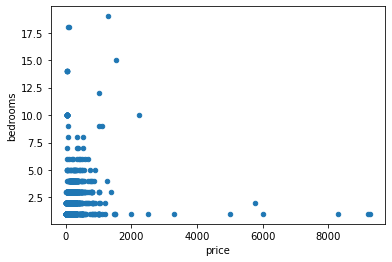

In [32]:
df_vienna_price.plot.scatter(x = 'price', y = 'bedrooms')

In [33]:
df_vienna_price = df_vienna_price[df_vienna_price['accommodates'] != 0]

In [34]:
df_vienna_price = df_vienna_price[df_vienna_price['price'] != 0]

I dropped rows where we had 0 accomodates and price because it does not make sense and we cannot put a value,also we had just 2 columns which had these values

In [35]:
df_vienna_price.bathroom_number.isnull().sum()

58

In [36]:
#average_bathroom = df_vienna_price['bathroom_number'].median()
#df_vienna_price['bathroom_number'] = df_vienna_price['bathroom_number'].fillna(value = average_bathroom)


df_vienna_price['bathroom_number'] = df_vienna_price['bathroom_number'].interpolate(method ='linear', limit_direction ='forward') 

<AxesSubplot:>

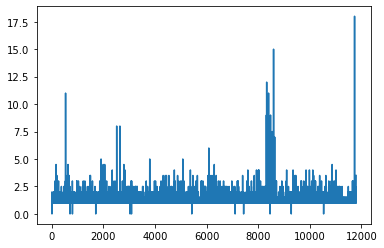

In [37]:
df_vienna_price['bathroom_number'].plot()

<AxesSubplot:xlabel='price', ylabel='accommodates'>

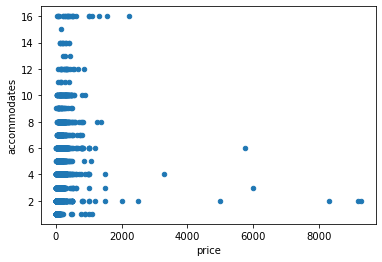

In [38]:
df_vienna_price.plot.scatter(x = 'price', y = 'accommodates')

In [39]:
average_reviewc = df_vienna_price['review_clean'].median()
average_reviewl = df_vienna_price['review_location'].median()







In [40]:
df_vienna_price['review_clean'] = df_vienna_price['review_clean'].fillna(value = average_reviewc)
df_vienna_price['review_location'] = df_vienna_price['review_location'].fillna(value = average_reviewl)






In [41]:
df_vienna_price.isnull().sum()

#Checking for missing values

accommodates                           0
bedrooms                               0
review_clean                           0
review_location                        0
price                                  0
neighbourhood_Alsergrund               0
neighbourhood_Brigittenau              0
neighbourhood_Dobling                  0
neighbourhood_Donaustadt               0
neighbourhood_Favoriten                0
neighbourhood_Floridsdorf              0
neighbourhood_Hernals                  0
neighbourhood_Hietzing                 0
neighbourhood_Innere Stadt             0
neighbourhood_Josefstadt               0
neighbourhood_Landstrase               0
neighbourhood_Leopoldstadt             0
neighbourhood_Liesing                  0
neighbourhood_Margareten               0
neighbourhood_Mariahilf                0
neighbourhood_Meidling                 0
neighbourhood_Neubau                   0
neighbourhood_Ottakring                0
neighbourhood_Penzing                  0
neighbourhood_Ru

<AxesSubplot:xlabel='price', ylabel='review_clean'>

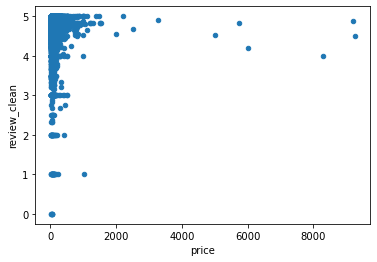

In [42]:
df_vienna_price.plot.scatter(x='price', y = 'review_clean')

## Checking for outliers

We have decided to replace outliers with random values that are below the range of the outliers
To understand outliers better, we have visualise them with outliers and after removing them


In [43]:
def price_outliers(noisy_data):
 

    cleaned_data = noisy_data.copy()
   
    sortedPrice = noisy_data.sort_values(['price'])
    sortedPrice = sortedPrice.loc[noisy_data['price']<=1750]
 
    
    
    cleaned_data.loc[noisy_data['price']>1750 ,'price'] = noisy_data.loc[noisy_data['price']>1750,'price'].apply(lambda x: np.random.choice(sortedPrice['price'].values, 1)[0])
    
    return cleaned_data

In [44]:
df_vienna_price = price_outliers(df_vienna_price)

<AxesSubplot:xlabel='price', ylabel='review_clean'>

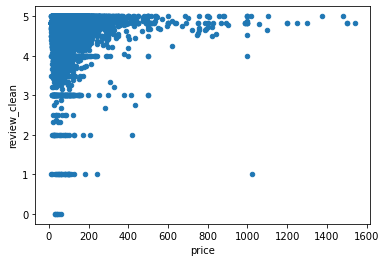

In [45]:
df_vienna_price.plot.scatter(x ='price', y='review_clean' )

In [46]:
def review_clean_outliers(noisy_data):
 

    cleaned_data = noisy_data.copy()
   
    sortedPrice = noisy_data.sort_values(['review_clean'])
    sortedPrice = sortedPrice.loc[noisy_data['review_clean']>=2]
 
    
    
    cleaned_data.loc[noisy_data['review_clean']<2 ,'review_clean'] = noisy_data.loc[noisy_data['review_clean']<2,'price'].apply(lambda x: np.random.choice(sortedPrice['review_clean'].values, 1)[0])
    
    return cleaned_data

In [47]:
df_vienna_price = review_clean_outliers(df_vienna_price)

In [48]:
df_vienna_price

,accommodates,bedrooms,review_clean,review_location,price,neighbourhood_Alsergrund,neighbourhood_Brigittenau,neighbourhood_Dobling,neighbourhood_Donaustadt,neighbourhood_Favoriten,...,Entire_home/apt,Hotel_room,Private_room,Shared_room,Parking,Wifi,Kitchen,Iron,Heating,Dryer
0,3,1,4.93,4.71,110.0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,1
1,5,1,4.65,4.75,69.0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,1,1
2,6,2,4.88,4.59,145.0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
3,2,1,4.55,4.89,100.0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
4,3,1,4.51,4.86,68.0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11792,5,2,4.83,4.81,170.0,0,0,0,1,0,...,1,0,0,0,1,1,1,1,1,1
11793,3,1,5.00,4.17,150.0,0,0,0,0,0,...,1,0,0,0,1,1,1,1,1,1
11794,8,2,3.00,5.00,150.0,0,0,0,0,0,...,1,0,0,0,1,1,1,0,1,1
11795,2,1,5.00,5.00,50.0,0,0,0,0,0,...,1,0,0,0,1,1,1,0,1,0


<AxesSubplot:xlabel='price', ylabel='review_location'>

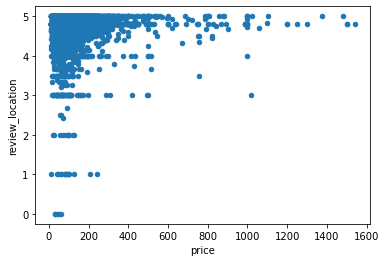

In [49]:
df_vienna_price.plot.scatter(x ='price', y='review_location')

In [50]:
def review_location_outliers(noisy_data):
 

    cleaned_data = noisy_data.copy()
   
    sortedPrice = noisy_data.sort_values(['review_location'])
    sortedPrice = sortedPrice.loc[noisy_data['review_location']>=2]
 
    
    
    cleaned_data.loc[noisy_data['review_location']<2 ,'review_location'] = noisy_data.loc[noisy_data['review_location']<2,'review_location'].apply(lambda x: np.random.choice(sortedPrice['review_location'].values, 1)[0])
    
    return cleaned_data

In [51]:
df_vienna_price = review_location_outliers(df_vienna_price)

<AxesSubplot:xlabel='price', ylabel='review_location'>

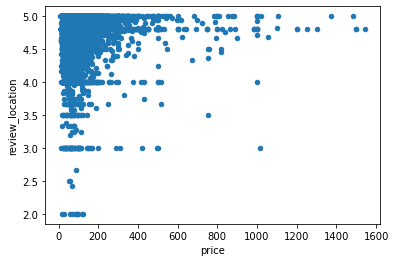

In [52]:
df_vienna_price.plot.scatter(x ='price', y='review_location')

<AxesSubplot:xlabel='price', ylabel='bedrooms'>

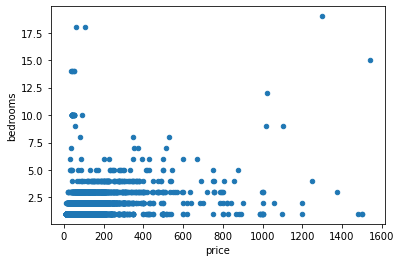

In [53]:
df_vienna_price.plot.scatter(x ='price', y='bedrooms')

In [54]:
def bedrooms_outliers(noisy_data):
 

    cleaned_data = noisy_data.copy()
   
    sortedPrice = noisy_data.sort_values(['bedrooms'])
    sortedPrice = sortedPrice.loc[noisy_data['bedrooms']<=7.5]
 
    
    
    cleaned_data.loc[noisy_data['bedrooms']>7.5 ,'bedrooms'] = noisy_data.loc[noisy_data['bedrooms']>7.5,'bedrooms'].apply(lambda x: np.random.choice(sortedPrice['bedrooms'].values, 1)[0])
    
    return cleaned_data

In [55]:
df_vienna_price = bedrooms_outliers(df_vienna_price)

<AxesSubplot:xlabel='price', ylabel='bedrooms'>

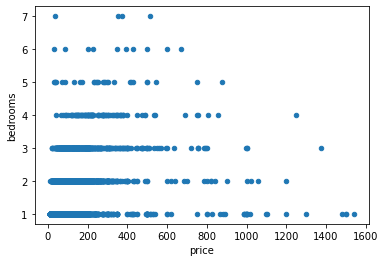

In [56]:
df_vienna_price.plot.scatter(x ='price', y='bedrooms')

<AxesSubplot:xlabel='price', ylabel='bathroom_number'>

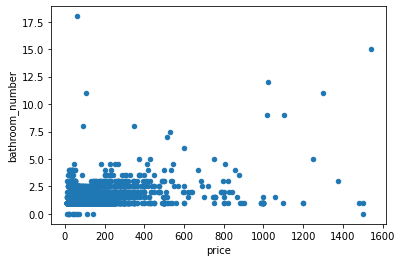

In [57]:
df_vienna_price.plot.scatter(x ='price', y='bathroom_number')

In [58]:
def bathroom_outliers(noisy_data):
 

    cleaned_data = noisy_data.copy()
   
    sortedPrice = noisy_data.sort_values(['bathroom_number'])
    sortedPrice = sortedPrice.loc[noisy_data['bathroom_number']<=5]
 
    
    
    cleaned_data.loc[noisy_data['bathroom_number']>5 ,'bathroom_number'] = noisy_data.loc[noisy_data['bathroom_number']>5,'bathroom_number'].apply(lambda x: np.random.choice(sortedPrice['bathroom_number'].values, 1)[0])
    
    return cleaned_data

In [59]:
df_vienna_price = bathroom_outliers(df_vienna_price)

<AxesSubplot:xlabel='price', ylabel='bathroom_number'>

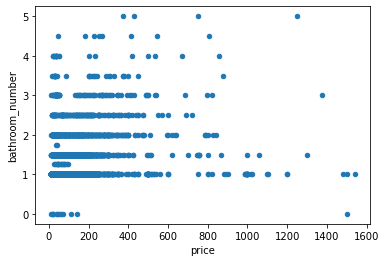

In [60]:
df_vienna_price.plot.scatter(x ='price', y='bathroom_number')

<AxesSubplot:ylabel='Frequency'>

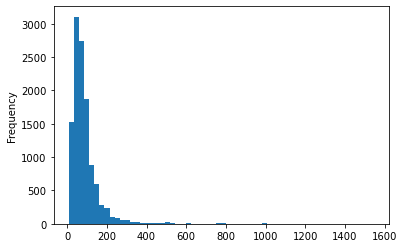

In [61]:
df_vienna_price['price'].plot.hist(x = 'price', bins = 60)

In [62]:
df_vienna_corr = df_vienna_price[['accommodates', 'bedrooms', 'review_clean',
       'review_location', 'price', 'bathroom_number',]]

In [63]:
df_vienna_corr

,accommodates,bedrooms,review_clean,review_location,price,bathroom_number
0,3,1,4.93,4.71,110.0,1.0
1,5,1,4.65,4.75,69.0,1.0
2,6,2,4.88,4.59,145.0,1.0
3,2,1,4.55,4.89,100.0,1.0
4,3,1,4.51,4.86,68.0,1.0
...,...,...,...,...,...,...
11792,5,2,4.83,4.81,170.0,2.0
11793,3,1,5.00,4.17,150.0,1.0
11794,8,2,3.00,5.00,150.0,1.0
11795,2,1,5.00,5.00,50.0,1.0


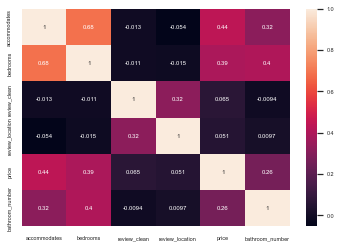

In [64]:
correlation = df_vienna_corr.corr(method='pearson')
columns = correlation.nlargest(9, 'price').index
correlation_map = np.corrcoef(df_vienna_corr.values.T)
sns.set(font_scale=0.5)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, yticklabels=df_vienna_corr.columns.values, xticklabels=df_vienna_corr.columns.values)

In [65]:
df_vienna_price.to_csv("df_price.csv")

## Correlation Matric

One correlation is between bedrooms and accomodates and it makes sense because you have to get enough beds and space for the accommodates you want to have in your airbnb

Price is mostly correlated with accommodates and now we have the information that price is mostly put by the number 

of people an airbnb can have.Price is also correlated with bedrooms .

The suprise here is that Price does not correlate with review_location or review_clean, which we had a feeling it would.

We can say that based on review for location given by guests, location does not affect the price for an AirBnB.

In [66]:
df_vienna_price.shape
df_vienna_price_hidden = df_vienna_price.iloc[:2359, :]

df_vienna_price_develop = df_vienna_price.iloc[2359:,:]

In [67]:
from sklearn import model_selection
X = df_vienna_price_develop.drop(columns='price')
Y = df_vienna_price_develop['price']
X_train = None
X_valid = None
y_train = None
y_valid = None
   
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X,Y, 
    test_size=0.2, random_state= 42)



## Making Prediction

We used Grid Search with 5 splits to find best parameters and then we tested machine learning models to estimate which one can do a better prediction.

Regression models that we used are : ElasticNet,Lasso,RandomForestRegreesor, KNeighboursRegressor, XGBRegressor, LinearRegression.
To estimate these models we used r2 score and mean absolute error
We also used Scalers to try reaching a better prediction and these scalers are : StandardScaler,MinMaxScaler,RobustScaler

In [68]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline, Pipeline

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


regressor = {"KNN": KNeighborsRegressor(),
            "RFG": RandomForestRegressor(),
            "Lso": Lasso()
              }


knn_param = { "n_neighbors": [2, 3, 5,10,15],
             "p": [1, 2], 
            "weights":["uniform", "distance"],
            "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "metric" : ['l1','l2','‘manhattan','euclidean']
             
            }

rgf_param = {"n_estimators" : [60],
            "max_depth": [4, 5, 6, 7, 8],
             "criterion" : ["squared_error", "absolute_error"],
             "warm_start" : [True]
            }

lasso_param = {'alpha': [1.0],
            "selection": ["cyclic", "random"],
            "copy_X" : [True],
            "fit_intercept" : [True]

            
            
            }

params = [knn_param, rgf_param, lasso_param]

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold




In [70]:
def train_models(regressor, params, train_data, train_classes):
    """"
    Does a GridSearchCV in different classifiers, returns the best 
    performing parameters per classifier and other metrics as result.
    """
    best_regression_scores = {}
    regressor_results = {}
    
    for idx, regression in enumerate(regressor.values()):
        
        
        clf = GridSearchCV(regression, params[idx], scoring=["r2"], cv=StratifiedKFold(n_splits=5),
                           verbose=4, refit="r2")
        clf.fit(train_data, train_classes)
        
        best_regression_scores.update({list(regressor.keys())[idx]: [clf.best_params_, clf.best_estimator_, clf.best_score_]})
        regressor_results.update({list(regressor.keys())[idx]: clf.cv_results_})

    return best_regression_scores, regressor_results

In [71]:

#regression_score, results = train_models(regressor,params,X_train,y_train)

{'KNN': [{'algorithm': 'kd_tree',
   'metric': 'l1',
   'n_neighbors': 15,
   'p': 1,
   'weights': 'distance'},
  KNeighborsRegressor(algorithm='kd_tree', metric='l1', n_neighbors=15, p=1,
                      weights='distance'),
  0.32766907753796853],
 'RFG': [{'criterion': 'absolute_error',
   'max_depth': 8,
   'n_estimators': 60,
   'warm_start': True},
  RandomForestRegressor(criterion='absolute_error', max_depth=8, n_estimators=60,
                        warm_start=True),
  0.328969958646976],
 'Lso': [{'alpha': 1.0,
   'copy_X': True,
   'fit_intercept': True,
   'selection': 'cyclic'},
  Lasso(),
  0.27291931567533395]}

In [72]:
X_train_scaled_e = StandardScaler().fit_transform(X_train)
X_valid_scaled_e = StandardScaler().fit_transform(X_valid)
model = ElasticNet(random_state = 0)
model.fit(X_train_scaled_e,y_train)
y_pred = model.predict(X_valid_scaled_e)
print(f"------------- Elastic Net r2 score --------------->  {r2_score(y_valid,y_pred)}")
print(f"------------- Elastic Net mae--------------->  {mean_absolute_error(y_valid,y_pred)}")

------------- Elastic Net r2 score --------------->  0.335248155315084
------------- Elastic Net mae--------------->  34.79194551118486


In [73]:
X_train_scaled_l = RobustScaler().fit_transform(X_train)
X_valid_scaled_l = RobustScaler().fit_transform(X_valid)
model = linear_model.Lasso(alpha=1.0,copy_X =  True,
   fit_intercept = True, selection = "cyclic")
model.fit(X_train_scaled_l,y_train)
y_pred = model.predict(X_valid_scaled_l)
print(f"------------- Lasso r2 score --------------->  {r2_score(y_valid,y_pred)}")
print(f"------------- Lasso mae--------------->  {mean_absolute_error(y_valid,y_pred)}")

------------- Lasso r2 score --------------->  0.3331342696366577
------------- Lasso mae--------------->  35.432686167182524


In [74]:
X_train_scaled_rfg = StandardScaler().fit_transform(X_train)
X_valid_scaled_rfg = StandardScaler().fit_transform(X_valid)
model =  RandomForestRegressor(criterion='absolute_error', max_depth=8, n_estimators=60,
                        warm_start=True)
model.fit(X_train_scaled_rfg,y_train)
y_pred = model.predict(X_valid_scaled_rfg)
print(f"------------- RandomForesstRegressor r2score --------------->  {r2_score(y_valid,y_pred)}")
print(f"------------- RandomForesstRegressor mae--------------->  {mean_absolute_error(y_valid,y_pred)}")


------------- RandomForesstRegressor r2score --------------->  0.43411713070223346
------------- RandomForesstRegressor mae--------------->  30.907379943502825


In [75]:
X_train_scaled_knn = StandardScaler().fit_transform(X_train)
X_valid_scaled_knn = StandardScaler().fit_transform(X_valid)
model = KNeighborsRegressor(algorithm='auto', metric='l1', n_neighbors=15,weights='distance', p = 1)
model.fit(X_train_scaled_knn,y_train)
y_pred = model.predict(X_valid_scaled_knn)
print(f"-------------  KNeighborsRegressor score --------------->  {r2_score(y_valid,y_pred)}")
print(f"------------- KNeighborsRegressor mae--------------->  {mean_absolute_error(y_valid,y_pred)}")



-------------  KNeighborsRegressor score --------------->  0.4796831717035994
------------- KNeighborsRegressor mae--------------->  31.559943707574394


In [76]:
import xgboost as xgb
X_train_scaled_xgb = StandardScaler().fit_transform(X_train)
X_valid_scaled_xgb = StandardScaler().fit_transform(X_valid)

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train_scaled_xgb,y_train)
y_pred_xgb = xgb_model.predict(X_valid_scaled_xgb)
print(f"-------------  XGBoost score --------------->  {r2_score(y_valid,y_pred)}")
print(f"------------- XGBoost mae--------------->  {mean_absolute_error(y_valid,y_pred)}")


[22:29:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
-------------  XGBoost score --------------->  0.4796831717035994
------------- XGBoost mae--------------->  31.559943707574394


We can see that the model with the best result was KNeighborsRegressor and XGboost. Now we continue with KNeighboursRegressor with r2 score = 0.4796831717035994


In [77]:
from sklearn.svm import SVR
X_train_scaled_linear = StandardScaler().fit_transform(X_train)
X_valid_scaled_linear = StandardScaler().fit_transform(X_valid)
model = SVR()
model.fit(X_train_scaled_linear,y_train)
y_pred = model.predict(X_valid_scaled_linear)
print(f"-------------  LinearRegressor score --------------->  {r2_score(y_valid,y_pred)}")
print(f"------------- LinearRegressor mae--------------->  {mean_absolute_error(y_valid,y_pred)}")





-------------  LinearRegressor score --------------->  0.20158176450681553
------------- LinearRegressor mae--------------->  33.02319559620095


In [78]:
def train_and_predict(X_train: pd.DataFrame, y_train: pd.Series, 
                      X_test: pd.DataFrame) -> np.ndarray:
   

    predictions = None
    X_train_scale = StandardScaler().fit_transform(X_train)
    X_test_scale = StandardScaler().fit_transform(X_test)
    regressor = KNeighborsRegressor(algorithm='auto', metric='l1', n_neighbors=15,weights='distance', p = 1)


    train_data = regressor.fit(X_train_scale,y_train)
    predictions = train_data.predict(X_test_scale)
    
    
    
    return predictions

In [79]:
X_train = df_vienna_price_develop.copy()
y_train = X_train['price']

X_test = df_vienna_price_hidden.copy()

del X_train['price']
del X_test['price']

vienna_price_prediction = train_and_predict(X_train, y_train, X_test)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


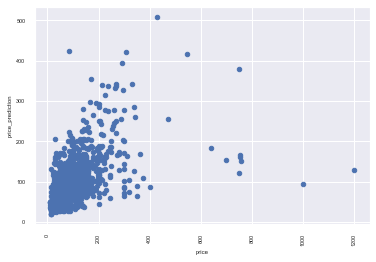

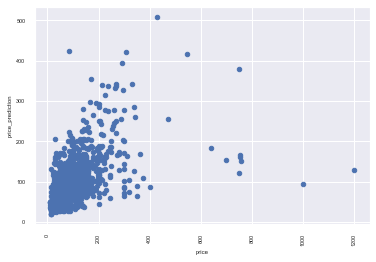

In [80]:
vienna_price = vienna_price_prediction.copy()
df_vienna_price_hidden = df_vienna_price_hidden.assign(price_prediction =vienna_price)
df_vienna_price_hidden.plot.scatter(x = 'price', y = 'price_prediction', rot=90).get_figure()
#ax = plt.title("Comparing ground truth with predictions")
#ax = plt.xlabel("Week")
#ax = plt.ylabel("Weekly Infections Values")

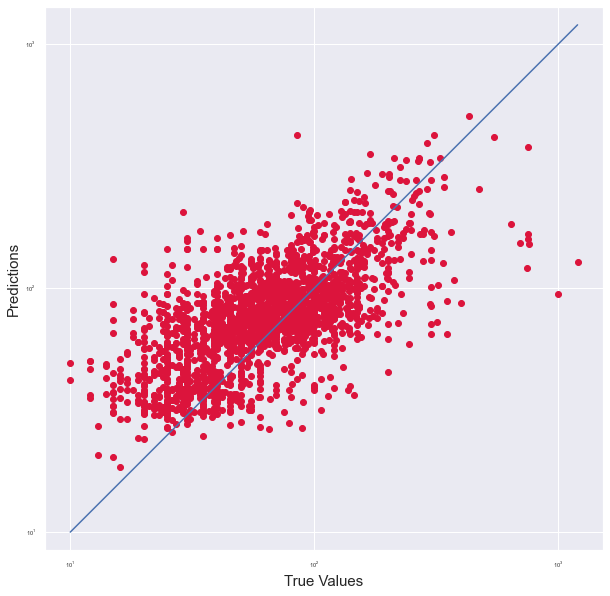

In [81]:
plt.figure(figsize=(10,10))
plt.scatter(df_vienna_price_hidden['price'],vienna_price_prediction, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(vienna_price_prediction), max(df_vienna_price_hidden['price']))
p2 = min(min(vienna_price_prediction), min(df_vienna_price_hidden['price']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()